<h1><center>Discounted Cash Flow - Single Company Valuation</center></h1>
<center>David Mohammadi</center>
<center>April 2022</center>


In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import datetime as dt
from datetime import datetime

import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [2]:
# financialmodelingprep API key to pull data with
from creds import api

# personally created functions for the DCF process, guidance from online lectures/websites
from dcf_calcs import (
    pull_company_financials,
    calculate_free_cash_flows_method_1,
    calculate_average_net_income_growth_equity_earnings_method,
    forecast_fcf,
    calculate_ratio_of_FCF_components_to_revenue,
    calculate_interest_coverage_ratio_and_synthetic_rating,
    pull_daily_stock_prices,
    calculate_company_expected_return_CAPM,
    calculate_WACC,
    calculate_terminal_enterprise_equity_values,
)

# Pull Company Financials/Data

In [3]:
years = 10
company_ticker = 'AAPL'

In [4]:
df_incomeStatement, df_balanceSheet, df_statementCashFlows, df_stockCharacteristics = pull_company_financials(
    company_ticker = company_ticker, 
    years = years, 
    api = api
)
df_incomeStatement.to_csv(f"financial_statements/IS_{company_ticker}_{years}yrs.csv")
df_balanceSheet.to_csv(f"financial_statements/BS_{company_ticker}_{years}yrs.csv")
df_statementCashFlows.to_csv(f"financial_statements/CF_{company_ticker}_{years}yrs.csv")
df_stockCharacteristics.to_csv(f"financial_statements/SC_{company_ticker}_{years}yrs.csv")

In [5]:
# # read in financials if I've already pulled from FinancialModelingPrep & saved to .csv (save on API credits)
# df_balanceSheet = pd.read_csv(
#     f"financial_statements/BS_{company_ticker}_{years}yrs.csv"
# ).sort_values("datetime", ascending = False)
# df_balanceSheet['datetime'] = pd.to_datetime(df_balanceSheet['date'])
# df_balanceSheet.set_index("calendarYear", inplace = True)

# df_incomeStatement = pd.read_csv(
#     f"financial_statements/IS_{company_ticker}_{years}yrs.csv"
# ).sort_values("datetime", ascending = False)
# df_incomeStatement['datetime'] = pd.to_datetime(df_incomeStatement['date'])
# df_incomeStatement.set_index("calendarYear", inplace = True)

# df_statementCashFlows = pd.read_csv(
#     f"financial_statements/CF_{company_ticker}_{years}yrs.csv"
# ).sort_values("datetime", ascending = False)
# df_statementCashFlows['datetime'] = pd.to_datetime(df_statementCashFlows['date'])
# df_statementCashFlows.set_index("calendarYear", inplace = True)

# df_stockCharacteristics = pd.read_csv(
#     f"financial_statements/SC_{company_ticker}_{years}yrs.csv"
# ).sort_values("datetime", ascending = False)
# df_stockCharacteristics['datetime'] = pd.to_datetime(df_stockCharacteristics['date'])
# df_stockCharacteristics.set_index("calendarYear", inplace = True)

---

# DCF Model - Process
Steps: 
1. Historical Free Cash Flow Calculation
1. Free Cash Flow Forecasting
    1. Estimating Growth
        - Growth via Equity Earnings & Return on Equity
        - Historical Growth
    1. Ratio: FCF Financial Components to Revenue
    1. Forecast Net Revenues & Calculate Future FCF
1. Weighted Average Cost of Capital (WACC) Calculation
    1. Cost of Debt
        - Interest Coverage Ratio & Synthetic Rating
    2. Cost of Equity
        - CAPM 
            - Pull stock price & index data
    3. Effective Tax Rate
1. Terminal, Enterprise & Equity Valuations



---

## 1. Historical Free Cash Flows to the Firm (FCFF)
Measurement of a company's profitability after all expenses and reinvestments

<b>
    <br>Net Income 
    <br>+ Depreciation & Amortization 
    <br>- Inc. in Working Capital
    <br>- Capital Expenditures (includes R&D)
<br>= FCF
</b>

Sources: 
- Aswath Damodaran: https://www.youtube.com/watch?v=8gYT3Xgs6NE
- Investopedia: https://www.investopedia.com/ask/answers/033015/what-formula-calculating-free-cash-flow.asp

In [6]:
df_fcf = pd.merge(
    df_incomeStatement[['date', 'datetime', 'revenue', 'netIncome', 'depreciationAndAmortization']],
    df_balanceSheet[['propertyPlantEquipmentNet', 'netReceivables', 'accountPayables', 'inventory']],
    left_index = True, right_index = True
)
df_fcf.index = df_fcf.index.astype(int)

# calculate FCF for each year of financials
for index_year in df_fcf.index.sort_values()[1:]:
    df_fcf.loc[index_year, ['free_cash_flow', 'change_working_cap', 'cap_ex']] = calculate_free_cash_flows_method_1(
        net_income = df_fcf.loc[index_year, 'netIncome'], 
        depr_amort_current_yr = df_fcf.loc[index_year, 'depreciationAndAmortization'], 
        depr_amort_previous_yr = df_fcf.loc[index_year-1, 'depreciationAndAmortization'], 
        ppe_current_yr = df_fcf.loc[index_year, 'propertyPlantEquipmentNet'], 
        ppe_previous_yr = df_fcf.loc[index_year-1, 'propertyPlantEquipmentNet'], 
        inventory_current_yr = df_fcf.loc[index_year, 'inventory'], 
        inventory_previous_yr = df_fcf.loc[index_year-1, 'inventory'],
        net_receivables_current_yr = df_fcf.loc[index_year, 'netReceivables'], 
        net_payables_current_yr = df_fcf.loc[index_year, 'accountPayables'],
        net_receivables_previous_yr = df_fcf.loc[index_year-1, 'netReceivables'], 
        net_payables_previous_yr = df_fcf.loc[index_year-1, 'accountPayables']
    )
    
df_fcf.sort_index(ascending = True, inplace = True)
df_fcf

,date,datetime,revenue,netIncome,depreciationAndAmortization,propertyPlantEquipmentNet,netReceivables,accountPayables,inventory,free_cash_flow,change_working_cap,cap_ex
calendarYear,,,,,,,,,,,,
2012,2012-09-29,2012-09-29,156508000000,41733000000,3277000000,15452000000,18692000000,21175000000,791000000,NaN,NaN,NaN
2013,2013-09-28,2013-09-28,170910000000,37037000000,6757000000,16597000000,20641000000,22367000000,1764000000,2.850100e+10,4.114000e+09,7.902000e+09
2014,2014-09-27,2014-09-27,182795000000,39510000000,7946000000,20624000000,27219000000,30196000000,2111000000,1.397200e+10,1.475400e+10,1.197300e+10
2015,2015-09-26,2015-09-26,233715000000,53394000000,11257000000,22471000000,30343000000,35490000000,2349000000,3.494500e+10,8.656000e+09,1.310400e+10
2016,2016-09-24,2016-09-24,215639000000,45687000000,10505000000,27010000000,29299000000,37294000000,2132000000,2.934800e+10,5.430000e+08,1.504400e+10
2017,2017-09-30,2017-09-30,229234000000,48351000000,10157000000,33783000000,35673000000,49049000000,4855000000,1.022100e+10,2.085200e+10,1.693000e+10
2018,2018-09-29,2018-09-29,265595000000,59531000000,10903000000,41304000000,48995000000,55888000000,3956000000,2.259100e+10,1.926200e+10,1.842400e+10
2019,2019-09-28,2019-09-28,260174000000,55256000000,12547000000,37378000000,45804000000,46236000000,4106000000,6.097200e+10,-1.269300e+10,8.621000e+09
2020,2020-09-26,2020-09-26,274515000000,57411000000,11056000000,36766000000,37445000000,42296000000,4061000000,5.782000e+10,-1.234400e+10,1.044400e+10


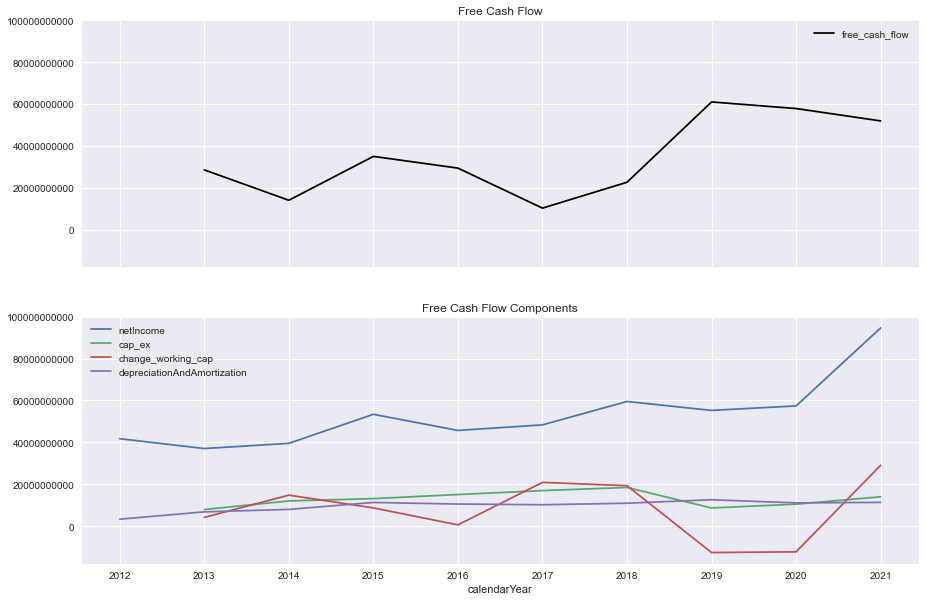

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize = [15, 10], sharex = True, sharey= True)

ax1 = df_fcf[['free_cash_flow']].plot(
    title = "Free Cash Flow", ax=axes[0], color = 'black')
ax1.ticklabel_format(style='plain')

ax2 = df_fcf[['netIncome', 'cap_ex', 'change_working_cap', 'depreciationAndAmortization']].plot(
    title = "Free Cash Flow Components", ax=axes[1])

ax1.set_xticks(df_fcf.index)
ax2.ticklabel_format(style='plain')
plt.show()

---

## 2. Forecasting Free Cash Flow - Percentage of Sales Method
- Determine the <b>estimated growth</b> in revenues
- Find the ratio of balance-sheet/income-statement items to revenue
- With the assumption that the ratio is constant, estimate the growth in the respective financial statement items
- Forcast FCF with these new metrics

### 2.A. Estimating Growth

#### Method 1: Equity Earnings by Return on Equity
- 1 method Dr. Aswath Damodaran suggests is looking at the company's retention rate and return on equity
    - Retention Ratio = 1-(Dividends/NetIncome)
    - Return on Equity = Net Income/Book Value Of Equity

<u>By multiplying Retention Ratio & Return on Equity, you can estimate the growth rate of Net Income as a proxy for Revenue</u>
<br>Aswath Damodaran Session 8: Estimating Growth - https://www.youtube.com/watch?v=fRNcP9xjk-8

In [8]:
average_net_income_growth_rate_equity_earnings_method = calculate_average_net_income_growth_equity_earnings_method(
    df_cashFlows_dividendsPaid = df_statementCashFlows.loc[:, 'dividendsPaid'], 
    df_incomeStatement_netIncome = df_incomeStatement.loc[:, 'netIncome'], 
    df_balanceSheet_bookValueEquity = df_balanceSheet.loc[:, 'totalEquity']
)

Average Growth Rate of Net Income = 44.95%


#### Method 2: Use historical revenue growth as the proxy for future growth

In [9]:
average_revenue_growth_rate_historical_method = df_fcf.sort_index(ascending = True)['revenue'].pct_change().mean()
print(f"Average Historical Growth Rate of Revenue = {round(100*average_revenue_growth_rate_historical_method, 2)}%")

Average Historical Growth Rate of Revenue = 10.58%


### 2.B. Ratios of FCF components to Revenue
- Using previous year financials to establish the ratios

In [10]:
most_recent_yr_financials = df_incomeStatement.index.max()
df_fcf_ratios = calculate_ratio_of_FCF_components_to_revenue(
    df_fcf, 
    ratio_year_set = 2021 # ratio_year_set = 'all' to use average ratio of all years
) 

df_fcf_ratios

,ratio_to_revenue
netIncome,0.258818
depreciationAndAmortization,0.030846
inventory,0.017987
propertyPlantEquipmentNet,0.107813
netReceivables,0.140797
accountPayables,0.149701


### 2.C. Forecast Revenue & Extrapolate Future FCF Values
<b> Extrapolate the next 5 years of values with the constant growth rate & ratios</b>
- Assumptions: 
    - The ratio of these lineitems will stay constant over the next 5 years
    - These lineitem values are directly related to net income
    - The growth rate of net income will remain relatively constant the next 5 years

In [11]:
list_yrs_to_forecast = list(range(df_statementCashFlows.index.max(),2027))
#list_yrs_to_forecast = list(range(2013, 2027))

In [12]:
df_FCF_forecast_equityEarningsGrowth = forecast_fcf(
    growth_rate_temp = average_net_income_growth_rate_equity_earnings_method, 
    df_freeCashFlow_forecasts = df_fcf.copy(), 
    list_years_to_forecast_temp = list_yrs_to_forecast,
    df_fcf_ratios = df_fcf_ratios
)

df_FCF_forecast_historicalGrowth = forecast_fcf(
    growth_rate_temp = average_revenue_growth_rate_historical_method, 
    df_freeCashFlow_forecasts = df_fcf, 
    list_years_to_forecast_temp = list_yrs_to_forecast,
    df_fcf_ratios = df_fcf_ratios
)

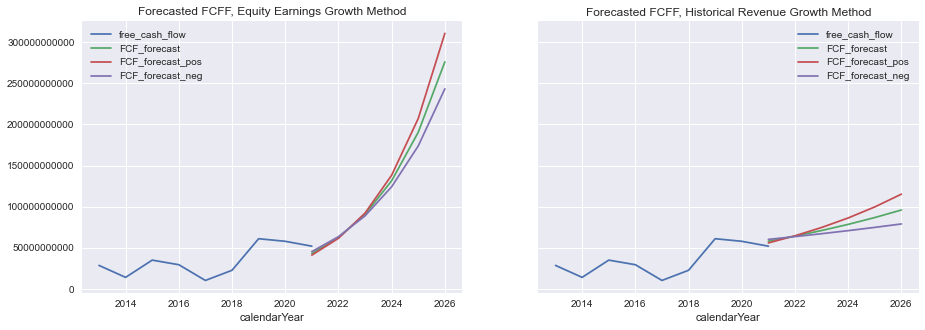

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = [15, 5], sharey = True)


ax1 = df_FCF_forecast_equityEarningsGrowth[
    ['free_cash_flow', 'FCF_forecast', 'FCF_forecast_pos', 'FCF_forecast_neg']
].plot(title = "Forecasted FCFF, Equity Earnings Growth Method", ax=axes[0])
ax1.ticklabel_format(style='plain')
ax2 = df_FCF_forecast_historicalGrowth[
    ['free_cash_flow', 'FCF_forecast', 'FCF_forecast_pos', 'FCF_forecast_neg']
].plot(title = "Forecasted FCFF, Historical Revenue Growth Method", ax=axes[1])

ax2.ticklabel_format(style='plain')
plt.show()

Note to self: If the Forecasted Free Cash Flows significantly differ than the point-in-time calculated Free Cash Flows, reasoning could be as follows: 
- Estimated Growth Rates are causing more pessimistic/optimistic valuations of Revenue which carries over to each FCF component
- The 2021 Ratio of FCF Component-to-Revenues is (higher/lower) than it used to be causing the Forecasted FCF to be (lower/higher) than it's point-in-time value
    - Relatively higher ratio to Revenue causes the Forecasted FCF to be lower
    - Relatively lower ratio to Revenue causes the Forecasted FCF to be higher

***

## 3. Weighted Average Cost of Capital (WACC)
WACC = [Cost of Debt * (1-Tax Rate) * (Debt/(Debt+Equity))] + [Cost of Equity * (Equity/(Debt+Equity))]

### 3.A. Cost of Debt
- Method: Estimate a synthetic rating
    - Aswath Damodaran: https://youtu.be/N_FH89DCdGs

1. Calculate <u>Interest Coverage Ratio</u> = EBIT/Interest Expenses
2. Map the Interest Coverage Ratio to a Credit/Credit-Spread
    - http://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/ratings.htm
3. Assumption: Risk Free Rate = 1.84%
    - https://ycharts.com/indicators/1_year_treasury_rate

In [14]:
risk_free_rate = 0.0184

<b>Interest Coverage Ratio & Synthetic Rating</b>

In [15]:
interest_coverage_ratio, cost_of_debt = calculate_interest_coverage_ratio_and_synthetic_rating(
    ebitda = df_incomeStatement.loc[2021, 'ebitda'], 
    deprAndAmort = df_incomeStatement.loc[2021, 'depreciationAndAmortization'], 
    interestExpense = df_incomeStatement.loc[2021, 'interestExpense'], 
    risk_free_rate = risk_free_rate
)


    Interest Coverage Ratio = 42.29
    Synthetic Rating = AAA
    Credit Default Spread = 0.67%
    Risk Free Rate = 1.84%
    Cost of Debt = 2.51%


### 3.B. Cost of Equity - Capital Asset Pricing Model (CAPM)

<b>Pull historical stock & index prices </b> 

In [16]:
list_tickers_daily_prices = ['SPY', company_ticker]

df_dailyStockPrices, df_dailyReturn, df_monthlyReturn = pull_daily_stock_prices(
    list_of_tickers = list_tickers_daily_prices, 
    market_data_startDate = df_incomeStatement['datetime'].min(), 
    market_data_endDate = df_incomeStatement['datetime'].max()
)

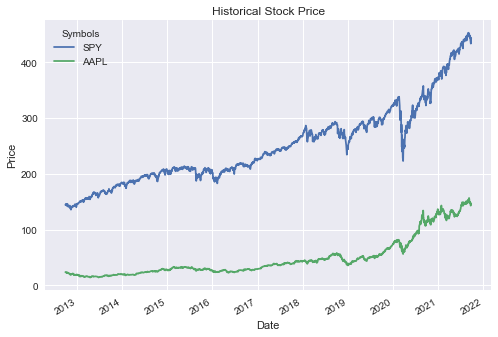

In [17]:
df_dailyStockPrices.plot()
plt.ylabel("Price")
plt.title("Historical Stock Price")
plt.show()

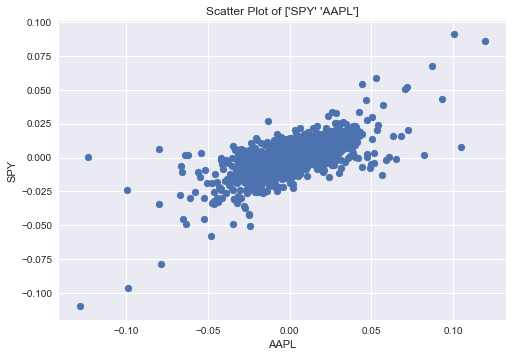

In [18]:
plt.scatter(df_dailyReturn.iloc[:, 1], df_dailyReturn.iloc[:, 0])
plt.title(f"Scatter Plot of {df_dailyReturn.columns.values}")
plt.xlabel(df_dailyReturn.iloc[:, 1].name)
plt.ylabel(df_dailyReturn.iloc[:, 0].name)
plt.show()

<b>Calculate Expected Stock Return (cost of equity) with CAPM model</b>

In [19]:
expected_stock_return, market_return = calculate_company_expected_return_CAPM(
    df_company_returns = df_dailyReturn['SPY'], 
    df_index_returns = df_dailyReturn[company_ticker],
    risk_free_rate = risk_free_rate, 
    company_ticker = company_ticker
)

Market Return = 24.52%
Expected Return (AAPL) = 10.62%


### 3.C. Effective Tax Rate
- For purposes of this exercise, I am calculating Total Debt & Total Equity to be measured against the total Debt + Equity book value, rather than the recommended Market Value
    - There is not a systematic way I know of (outside of the Bloomberg Terminal for example) to get a company's average maturity on outstanding debt
- Effective tax rate = Income Tax Expense/Earnings Before Taxes
    - https://www.investopedia.com/ask/answers/102714/how-are-effective-tax-rates-calculated-income-statements.asp

In [20]:
effective_tax_rate = (
    df_incomeStatement.loc[2021, 'incomeTaxExpense']/(
        df_incomeStatement.loc[2021, 'ebitda'] 
        - df_incomeStatement.loc[2021, 'depreciationAndAmortization']
    )
)

In [21]:
wacc = calculate_WACC(
    total_equity = df_balanceSheet.loc[2021, 'totalStockholdersEquity'], 
    total_debt = df_balanceSheet.loc[2021, 'totalDebt'], 
    eff_tax_rate = effective_tax_rate, 
    stock_return = expected_stock_return,
    cost_of_debt = cost_of_debt
)

Weighted Average Cost of Capital (WACC) = 5.02%


---

## 4. Terminal, Enterprise & Equity Valuations
- <b>Terminal Value:</b> Estimated value of a business beyond forecast period
    - Terminal Value = [Forecasted FCF * (1+g)]/(WACC - g)
- <b>Enterprise Value:</b> Total value of the assets of the business (excluding cash)
    - Enterprise Value = PV(all Forecasted Free Cash Flows + Terminal Value)
- <b>Equity Value:</b> Total value of a business, attributable to the shareholders.
    - Equity Value = (Enterprise Value + Cash - Debt)/#-shares-outstanding


In [22]:
print(f"Current {company_ticker} Stock Price: $", round(df_stockCharacteristics.loc[2021, 'stockPrice'], 2))

Current AAPL Stock Price: $ 148.64


In [23]:
terminal_values_earningsGrowthMethod, df_equity_values_earningsGrowthMethod = calculate_terminal_enterprise_equity_values(
    df_FCF_selectedGrowthMethod = df_FCF_forecast_equityEarningsGrowth, 
    wacc = wacc, 
    cashAndCashEquivalents = df_balanceSheet.loc[2021, 'cashAndCashEquivalents'], 
    totalDebt = df_balanceSheet.loc[2021, 'totalDebt'], 
    numShares = df_stockCharacteristics.loc[2021, 'numberOfShares']
)
df_equity_values_earningsGrowthMethod

,npv_FCFF,terminal_value_discounted,enterprise_value,estimate_stock_price
neutral_outlook,6.594629e+11,7.30341e+12,7.96287e+12,471.407
positive_outlook,7.088925e+11,8.21955e+12,8.92844e+12,529.221
negative_outlook,6.105866e+11,6.43468e+12,7.04527e+12,416.465


In [24]:
terminal_values_historicalGrowthMethod, df_equity_values_historicalGrowthMethod = calculate_terminal_enterprise_equity_values(
    df_FCF_selectedGrowthMethod = df_FCF_forecast_historicalGrowth, 
    wacc = wacc, 
    cashAndCashEquivalents = df_balanceSheet.loc[2021, 'cashAndCashEquivalents'], 
    totalDebt = df_balanceSheet.loc[2021, 'totalDebt'], 
    numShares = df_stockCharacteristics.loc[2021, 'numberOfShares']
)
df_equity_values_historicalGrowthMethod

,npv_FCFF,terminal_value_discounted,enterprise_value,estimate_stock_price
neutral_outlook,3.565049e+11,2.53659e+12,2.8931e+12,167.851
positive_outlook,3.944731e+11,3.04645e+12,3.44092e+12,200.652
negative_outlook,3.210144e+11,2.08766e+12,2.40868e+12,138.846


---

# <center>Review Results</center>

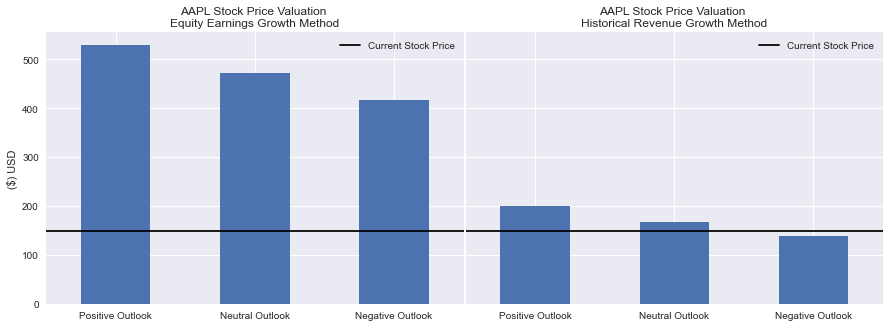

In [97]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = [15, 5], sharey= True)
fig.subplots_adjust(wspace=0.005)

ax1 = df_equity_values_earningsGrowthMethod.loc[
    ['positive_outlook', 'neutral_outlook', 'negative_outlook'], 'estimate_stock_price'
].plot.bar(
    title = f"{company_ticker} Stock Price Valuation \nEquity Earnings Growth Method", ax=axes[0],
    label='_nolegend_'
)
ax1.axhline(y=df_stockCharacteristics.loc[2021, 'stockPrice'], color='black', label = 'Current Stock Price')


ax2 = df_equity_values_historicalGrowthMethod.loc[
    ['positive_outlook', 'neutral_outlook', 'negative_outlook'], 'estimate_stock_price'
].plot.bar(
    title = f"{company_ticker} Stock Price Valuation \nHistorical Revenue Growth Method", ax=axes[1],
    label='_nolegend_'
)
ax2.axhline(y=df_stockCharacteristics.loc[2021, 'stockPrice'], color='black', label = 'Current Stock Price')

ax1.set_xticklabels(["Positive Outlook", 'Neutral Outlook', 'Negative Outlook'], rotation=0)
ax2.set_xticklabels(["Positive Outlook", 'Neutral Outlook', 'Negative Outlook'], rotation=0)
ax1.legend()
ax2.legend()

ax1.set_ylabel("($) USD")
plt.show()

Above graph depicts the stock market valuations from above DCF model using both types of growth calculations: 
1. Equity Earnings Growth (Looking at retention ratio & return on equity)
2. Historical Revenue Growth 

Each growth calculation method shows varying outlooks with a (+/-) 5% buffer added to the original (neutral) growth rate. <br>Horizontal black line shows current stock price